In [1]:
# Data manipulation
import pandas as pd
import numpy as np
#from pint import UnitRegistry
#u = UnitRegistry()
#u.default_format = 'C'
#import math as m

# Display all cell outputs
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'

#from IPython import get_ipython
#ipython = get_ipython()
#from IPython.display import display_latex

# autoreload extension
#if 'autoreload' not in ipython.extension_manager.loaded:
#    %load_ext autoreload

#%autoreload 2

# Visualizations
#%matplotlib inline
import matplotlib.pyplot as plt
h = 10
w = h*1.61803398875
font = {'family' : 'Times New Roman',
        'weight' : 'bold'}

from matplotlib import rc
plt.rc('font',**{'family':'Times New Roman', 'size': 20})
plt.rc('text', usetex=True)
# Publish
# from ipypublish.scripts import nb_setup

In [2]:
def kb_eq(df,charge_config,units,blast_param,distance):
    coef_df_u = df[(df.charge_configuration == charge_config) &
                 (df.system_of_units == units) &
                 (df.blast_parameter == blast_param) &
                 (df.variable == 'U')]
    coef_df_y = df[(df.charge_configuration == charge_config) &
                 (df.system_of_units == units) &
                 (df.blast_parameter == blast_param) &
                 (df.variable == 'Y')]
    num_eq_u = np.size(coef_df_u.function.unique())
    #num_eq_y = np.size(coef_df_y.function.unique())
    lower_range = df[(df.charge_configuration == charge_config) & # the lower distance the equation is 
                     (df.system_of_units == units) &              # valid over.
                     (df.blast_parameter == blast_param)].lower_range.unique()
    upper_range = df[(df.charge_configuration == charge_config) & # the upper range the equaiton is valid
                     (df.system_of_units == units) &              # over.
                     (df.blast_parameter == blast_param)].upper_range.unique()

    u = 0
    U = np.empty((0, 3))
    U_eq = np.empty((0, 100))
    d = []
    y = 0
    Y = []
    for each_u_eq in range(0,num_eq_u): # cycle through the number of u equations.
        dsub = distance[(distance>lower_range[each_u_eq]) & # valid distances for the kb equation.
                        (distance<=upper_range[each_u_eq])]
        dist = np.array2string(dsub)
        #print(blast_param)
        #print('{:.3f} <= {} < {:.3f}'.format(lower_range[each_u_eq],dist,upper_range[each_u_eq]))
        c_u = coef_df_u.coefficients[(coef_df_u.function == each_u_eq+1)] # u coefficients for an equation.
        c_y = coef_df_y.coefficients[(coef_df_y.function == each_u_eq+1)] # y coefficients for an equation.
        for each_dist in np.log10(dsub): # cycle through the valid distances
            d.append(each_dist)
            n = 0 # resets the power in the u function to zero
            for each_u_coef in c_u: # cycle through the coefficients in the function.
                #print(each_u_coef)
                #print('U:{0:.3f} + {1:.3f}*{2:.3f}**{3:.3f} = {4:.3f}'.format(u,each_u_coef,each_dist,n,u + each_u_coef*each_dist**n))
                u = u + each_u_coef*each_dist**n # sum's the function terms together
                n += 1 # increments to the next term in the function
            m = 0 # resets the power in the y function to zero
            for each_y_coef in c_y: # cycle through y coefficients in the function at a given u
                #print('Y:{0:.3f} + {1:.3f}*{2:.3f}**{3:.3f} = {4:.1f}'.format(y,each_y_coef,u,m,y + each_y_coef*u**m))
                y = y + each_y_coef*u**m # totals the y's together
                m += 1 # increments to the next term in the function
            Y.append(y)
            y = 0
            u = 0
    return np.asarray(Y), np.asarray(d)

In [3]:
filename = 'kb_equation_data.csv'
df = pd.read_csv(filename)
#distance = np.asarray([0.1,10,100])
distance = np.arange(0.1,100,0.1)
Ps,dPs = kb_eq(df,'hemispherical','imperial','incident_pressure',distance)
Pr,dPr = kb_eq(df,'hemispherical','imperial','reflected_pressure',distance)
Is,dIs = kb_eq(df,'hemispherical','imperial','incident_impulse',distance)
Ir,dIr = kb_eq(df,'hemispherical','imperial','reflected_impulse',distance)
tp,dtp = kb_eq(df,'hemispherical','imperial','positive_phase_duration',distance)
ta,dta = kb_eq(df,'hemispherical','imperial','arrival_time',distance)
U,dU = kb_eq(df,'hemispherical','imperial','shock_front_velocity',distance)

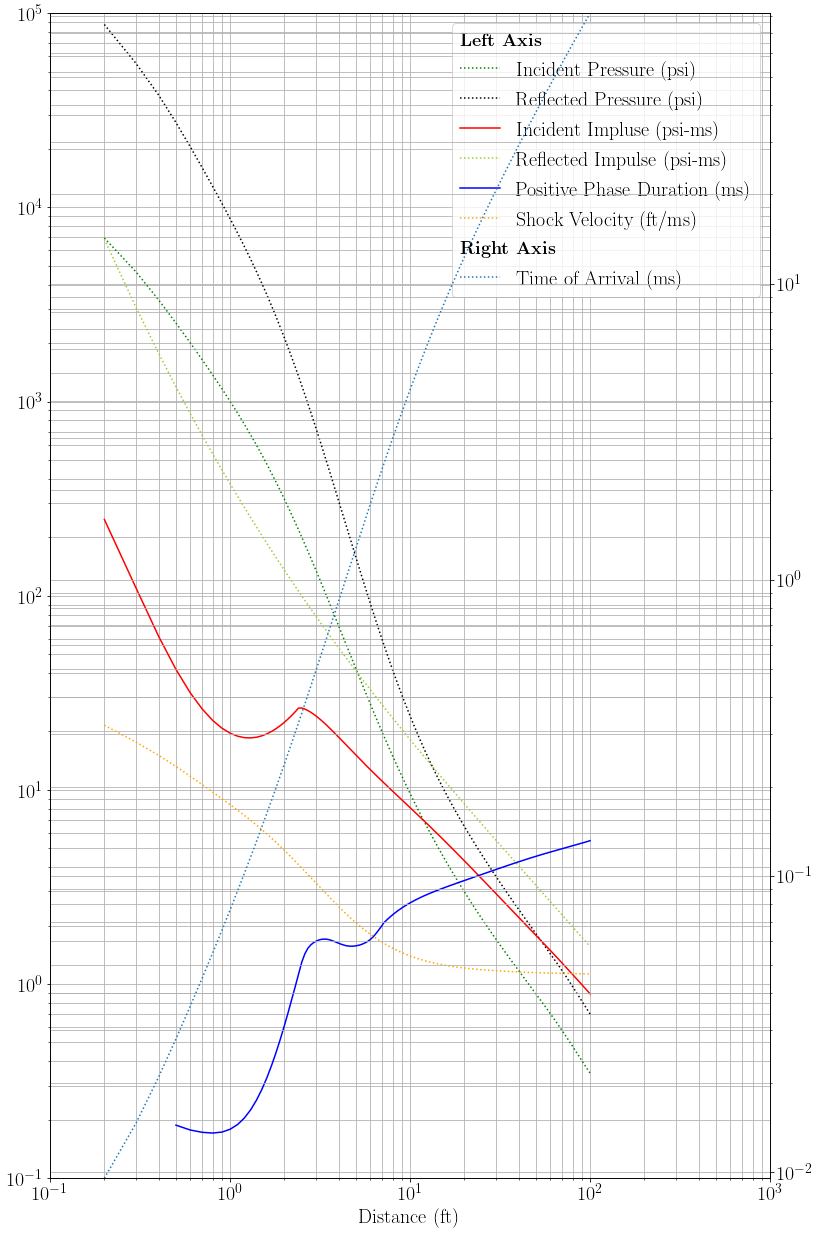

In [17]:
import matplotlib.text as mtext

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, r'\bf{' + orig_handle + '}', usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title

fig, ax1 = plt.subplots(figsize=(h,w));
ax2 = ax1.twinx();
ax1.set_xlabel('Distance (ft)');
ax1.set_ylim(0.1,100000);
ax1.set_xlim(0.1,1000);

[lns1] = ax1.loglog(10**dPs,10**Ps,color='green', linestyle=':', label='Incident Pressure (psi)');
[lns2] = ax1.loglog(10**dPr,10**Pr,color='black', linestyle=':', label='Reflected Pressure (psi)');
[lns3] = ax1.loglog(10**dIs,10**Is,color='red', label='Incident Impluse (psi-ms)');
[lns4] = ax1.loglog(10**dIr,10**Ir,color='yellowgreen', linestyle=':', label='Reflected Impulse (psi-ms)');
[lns5] = ax1.loglog(10**dtp,10**tp,color='blue', label='Positive Phase Duration (ms)');
[lns6] = ax1.loglog(10**dU,10**U,color='orange', linestyle=':', label='Shock Velocity (ft/ms)');
[lns7] = ax2.loglog(10**dta,10**ta, linestyle=':', label='Time of Arrival (ms)');

lns = ['Left Axis', lns1, lns2, lns3, lns4, lns5, lns6, 'Right Axis', lns7];
titles = ['', 'Incident Pressure (psi)','Reflected Pressure (psi)','Incident Impluse (psi-ms)', 'Reflected Impulse (psi-ms)',
          'Positive Phase Duration (ms)','Shock Velocity (ft/ms)','', 'Time of Arrival (ms)']
ax1.legend(lns, titles,handler_map={str: LegendTitle({'fontsize': 18})}, loc=1)
ax1.grid(True, which="both");
ax2.grid(True, which="both");

#plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("/Users/skmcneill/Documents/github/phd_comprehensive/figures/hemispherical_metric_all.png", bbox_inches = 'tight',
    pad_inches = 0.1)

# Airblast Parameters From TNT Spherical Air Burst and Hemispherical Surface Burst
*S. Kevin McNeill*

*August 28, 2019*

## Analysis
This notebook will plot the following blast parameters for spherical air burst and hemispherical surface burst in both imperial and metric units:
* incident pressure
* incident impulse
* reflected pressure
* reflected impulse
* shock front velocity
* arrival time
* positive phase duration


## Data
Data for these plots was built from the original paper *Airblast Parameters from TNT Spherical Air Burst and Hemispherical Surface Burst* by Charles N. Kingery and Gerald Bulmash.  It was hand typed into excel and then saved as a HDF5 file.

## References